In [1]:
!pip install openai-clip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 21.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.6 MB/s eta 0:00:00
  Created wheel for openai-clip: filename=openai_clip-1.0.1-py3-none-any.whl size=1368605 sha256=ff41dc14e7786877a2941f4bb702960ff64d6e7ed83025cbe5aba98a11a33391
  Stored in directory: /root/.cache/pip/wheels/ab/49/bc/c2342e8e14878210ba4825cf314a53f2570f6fb18b91fce3cf
Successfully built openai-clip


In [2]:
# CLIP Modality Gap Assignment
# Task 5: Exploring and Bridging the Modality Gap in CLIP

# Import required libraries
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import umap
from scipy.linalg import orthogonal_procrustes
import clip
from PIL import Image
import random
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Check if GPU is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")


Using device: cuda



=== Task 5.1: Zero-Shot Classification on STL-10 ===


100%|██████████| 2.64G/2.64G [04:10<00:00, 10.5MB/s]


STL-10 test set loaded: 8000 samples
Classes: ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']

Loading CLIP model...


100%|████████████████████████████████████████| 338M/338M [00:01<00:00, 200MiB/s]


CLIP model loaded successfully!

Evaluating with plain labels...


Evaluating: 100%|██████████| 250/250 [00:20<00:00, 12.41it/s]


Plain labels accuracy: 0.9389

Evaluating with simple prompts...


Evaluating: 100%|██████████| 250/250 [00:19<00:00, 13.10it/s]


Simple prompt accuracy: 0.9485

Evaluating with descriptive prompts...


Evaluating: 100%|██████████| 250/250 [00:18<00:00, 13.23it/s]


Descriptive prompts accuracy: 0.9483


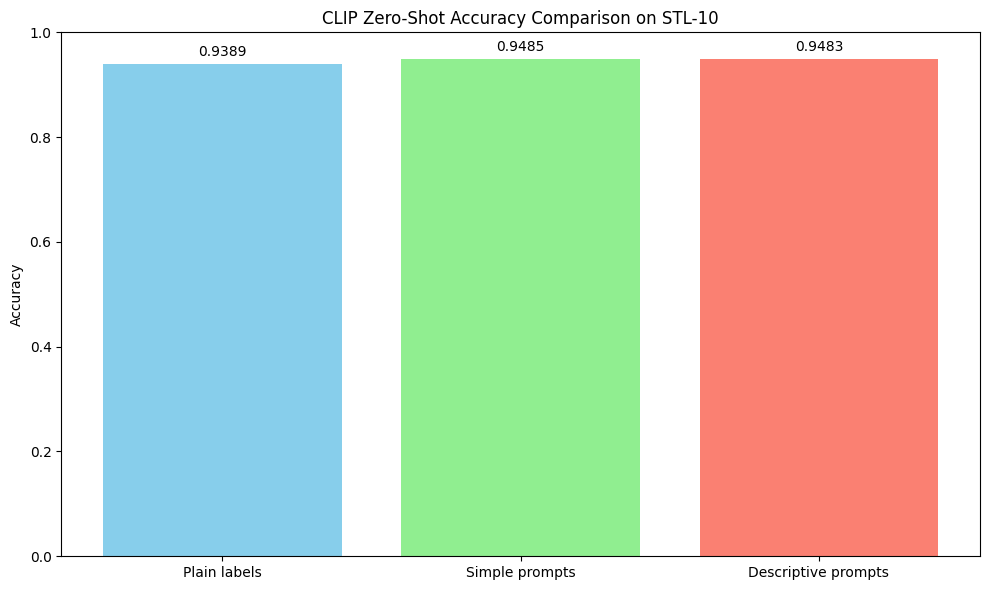


Accuracy Results Summary:
Plain labels: 0.9389
Simple prompts: 0.9485
Descriptive prompts: 0.9483


In [3]:

#===============================================================================
# TASK 5.1: Zero-Shot Classification on STL-10
#===============================================================================

print("\n=== Task 5.1: Zero-Shot Classification on STL-10 ===")

# (a) Download STL-10 dataset
print("Downloading STL-10 dataset...")
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

# Download test set
test_dataset = torchvision.datasets.STL10(
    root='./data',
    split='test',
    download=True,
    transform=transform
)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# STL-10 class names
stl10_classes = ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']

print(f"STL-10 test set loaded: {len(test_dataset)} samples")
print(f"Classes: {stl10_classes}")

# (b) Load OpenAI's CLIP model
print("\nLoading CLIP model...")
model, preprocess = clip.load("ViT-B/32", device=device)
print("CLIP model loaded successfully!")

# (c) Evaluate CLIP with different prompting techniques

def evaluate_clip_accuracy(model, test_loader, class_names, text_templates, device):
    """Evaluate CLIP zero-shot accuracy with given text templates"""
    model.eval()

    # Prepare text inputs
    text_inputs = []
    for template in text_templates:
        for class_name in class_names:
            text_inputs.append(template.format(class_name))

    # Encode text
    text_tokens = clip.tokenize(text_inputs).to(device)

    with torch.no_grad():
        text_features = model.encode_text(text_tokens)
        text_features = F.normalize(text_features, dim=-1)

    # Reshape text features: [num_templates, num_classes, feature_dim]
    text_features = text_features.view(len(text_templates), len(class_names), -1)

    # Average across templates if multiple templates
    if len(text_templates) > 1:
        text_features = text_features.mean(dim=0)
    else:
        text_features = text_features.squeeze(0)

    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating"):
            images = images.to(device)
            labels = labels.to(device)

            # Encode images
            image_features = model.encode_image(images)
            image_features = F.normalize(image_features, dim=-1)

            # Compute similarities
            similarities = image_features @ text_features.T
            predicted = similarities.argmax(dim=-1)

            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    return accuracy

# i. Plain labels
print("\nEvaluating with plain labels...")
plain_templates = ["{}"]
plain_accuracy = evaluate_clip_accuracy(model, test_loader, stl10_classes, plain_templates, device)
print(f"Plain labels accuracy: {plain_accuracy:.4f}")

# ii. Prompted text
print("\nEvaluating with simple prompts...")
simple_templates = ["a photo of a {}"]
simple_accuracy = evaluate_clip_accuracy(model, test_loader, stl10_classes, simple_templates, device)
print(f"Simple prompt accuracy: {simple_accuracy:.4f}")

# iii. More descriptive variants
print("\nEvaluating with descriptive prompts...")
descriptive_templates = [
    "a photo of a {}",
    "a picture of a {}",
    "an image of a {}",
    "a high quality photo of a {}",
    "a clear image of a {}"
]
descriptive_accuracy = evaluate_clip_accuracy(model, test_loader, stl10_classes, descriptive_templates, device)
print(f"Descriptive prompts accuracy: {descriptive_accuracy:.4f}")

# Store results for comparison
accuracy_results = {
    'Plain labels': plain_accuracy,
    'Simple prompts': simple_accuracy,
    'Descriptive prompts': descriptive_accuracy
}

# Plot comparison
plt.figure(figsize=(10, 6))
strategies = list(accuracy_results.keys())
accuracies = list(accuracy_results.values())

plt.bar(strategies, accuracies, color=['skyblue', 'lightgreen', 'salmon'])
plt.title('CLIP Zero-Shot Accuracy Comparison on STL-10')
plt.ylabel('Accuracy')
plt.ylim(0, 1)

for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.01, f'{acc:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print(f"\nAccuracy Results Summary:")
for strategy, acc in accuracy_results.items():
    print(f"{strategy}: {acc:.4f}")



=== Task 5.2: Exploring the Modality Gap ===
Extracting embeddings for subset of STL-10...
Extracted embeddings: 100 samples
Image embeddings shape: torch.Size([100, 512])
Text embeddings shape: torch.Size([100, 512])

Performing dimensionality reduction...


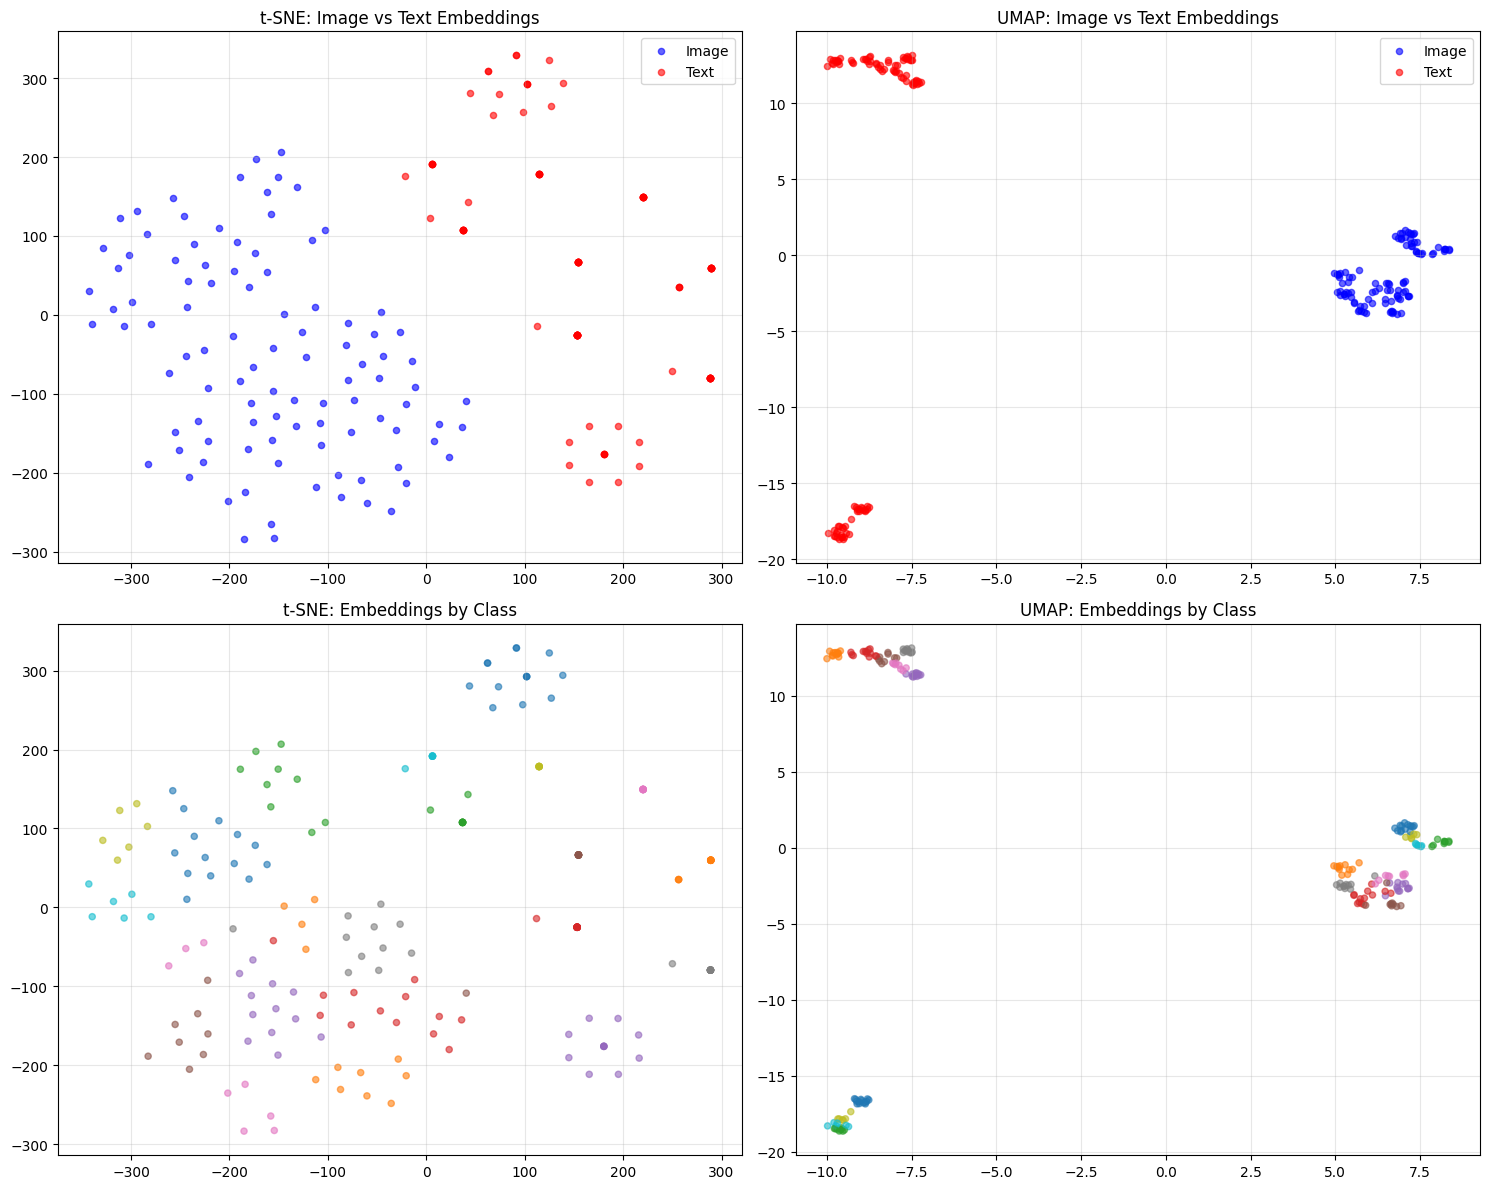


Embedding Statistics:
Image embeddings - Mean norm: 10.7969
Text embeddings - Mean norm: 10.1328
Normalized image embeddings - Mean norm: 1.0000
Normalized text embeddings - Mean norm: 1.0000
Mean diagonal similarity (correct pairs): 0.2791
Mean off-diagonal similarity: 0.2175


In [4]:

#===============================================================================
# TASK 5.2: Exploring the Modality Gap
#===============================================================================

print("\n=== Task 5.2: Exploring the Modality Gap ===")

# (a) Extract embeddings for a subset of STL-10
print("Extracting embeddings for subset of STL-10...")

# Select a subset of samples
subset_size = 100
subset_indices = random.sample(range(len(test_dataset)), subset_size)
subset_data = torch.utils.data.Subset(test_dataset, subset_indices)
subset_loader = torch.utils.data.DataLoader(subset_data, batch_size=32, shuffle=False)

# Extract image and text embeddings
image_embeddings = []
text_embeddings = []
labels_list = []

model.eval()
with torch.no_grad():
    # Extract image embeddings
    for images, labels in subset_loader:
        images = images.to(device)
        img_features = model.encode_image(images)
        image_embeddings.append(img_features.cpu())
        labels_list.extend(labels.numpy())

    image_embeddings = torch.cat(image_embeddings, dim=0)

    # Extract text embeddings for corresponding labels
    text_inputs = [f"a photo of a {stl10_classes[label]}" for label in labels_list]
    text_tokens = clip.tokenize(text_inputs).to(device)
    text_features = model.encode_text(text_tokens)
    text_embeddings = text_features.cpu()

print(f"Extracted embeddings: {image_embeddings.shape[0]} samples")
print(f"Image embeddings shape: {image_embeddings.shape}")
print(f"Text embeddings shape: {text_embeddings.shape}")

# (b) Dimensionality reduction with t-SNE and UMAP
print("\nPerforming dimensionality reduction...")

# Combine embeddings for visualization
all_embeddings = torch.cat([image_embeddings, text_embeddings], dim=0)
all_embeddings_np = all_embeddings.numpy()

# Create labels for modalities
modality_labels = ['Image'] * len(image_embeddings) + ['Text'] * len(text_embeddings)
class_labels = labels_list + labels_list  # Same class labels for both modalities

# t-SNE reduction
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_tsne = tsne.fit_transform(all_embeddings_np)

# UMAP reduction
umap_reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
embeddings_umap = umap_reducer.fit_transform(all_embeddings_np)

# (c) Visualize embeddings
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# t-SNE visualization by modality
scatter1 = axes[0, 0].scatter(embeddings_tsne[:len(image_embeddings), 0],
                             embeddings_tsne[:len(image_embeddings), 1],
                             c='blue', alpha=0.6, label='Image', s=20)
scatter2 = axes[0, 0].scatter(embeddings_tsne[len(image_embeddings):, 0],
                             embeddings_tsne[len(image_embeddings):, 1],
                             c='red', alpha=0.6, label='Text', s=20)
axes[0, 0].set_title('t-SNE: Image vs Text Embeddings')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# UMAP visualization by modality
axes[0, 1].scatter(embeddings_umap[:len(image_embeddings), 0],
                  embeddings_umap[:len(image_embeddings), 1],
                  c='blue', alpha=0.6, label='Image', s=20)
axes[0, 1].scatter(embeddings_umap[len(image_embeddings):, 0],
                  embeddings_umap[len(image_embeddings):, 1],
                  c='red', alpha=0.6, label='Text', s=20)
axes[0, 1].set_title('UMAP: Image vs Text Embeddings')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# t-SNE visualization by class
class_colors = plt.cm.tab10(np.array(class_labels) / 9.0)
axes[1, 0].scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1],
                  c=class_colors, alpha=0.6, s=20)
axes[1, 0].set_title('t-SNE: Embeddings by Class')
axes[1, 0].grid(True, alpha=0.3)

# UMAP visualization by class
axes[1, 1].scatter(embeddings_umap[:, 0], embeddings_umap[:, 1],
                  c=class_colors, alpha=0.6, s=20)
axes[1, 1].set_title('UMAP: Embeddings by Class')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Analyze embedding statistics
print("\nEmbedding Statistics:")
print(f"Image embeddings - Mean norm: {torch.norm(image_embeddings, dim=1).mean():.4f}")
print(f"Text embeddings - Mean norm: {torch.norm(text_embeddings, dim=1).mean():.4f}")

# Normalize embeddings and compare
image_embeddings_norm = F.normalize(image_embeddings, dim=1)
text_embeddings_norm = F.normalize(text_embeddings, dim=1)

print(f"Normalized image embeddings - Mean norm: {torch.norm(image_embeddings_norm, dim=1).mean():.4f}")
print(f"Normalized text embeddings - Mean norm: {torch.norm(text_embeddings_norm, dim=1).mean():.4f}")

# Compute pairwise similarities
similarities = torch.mm(image_embeddings_norm, text_embeddings_norm.T)
diagonal_similarities = torch.diag(similarities)
print(f"Mean diagonal similarity (correct pairs): {diagonal_similarities.mean():.4f}")
print(f"Mean off-diagonal similarity: {(similarities.sum() - diagonal_similarities.sum()) / (similarities.numel() - len(diagonal_similarities)):.4f}")



=== Task 5.3: Bridging the Modality Gap ===
Learning optimal rotation matrix...
Learned rotation matrix R shape: (512, 512)
Procrustes scale factor: 89.1015
Applying rotation transform...
Visualizing aligned embeddings...


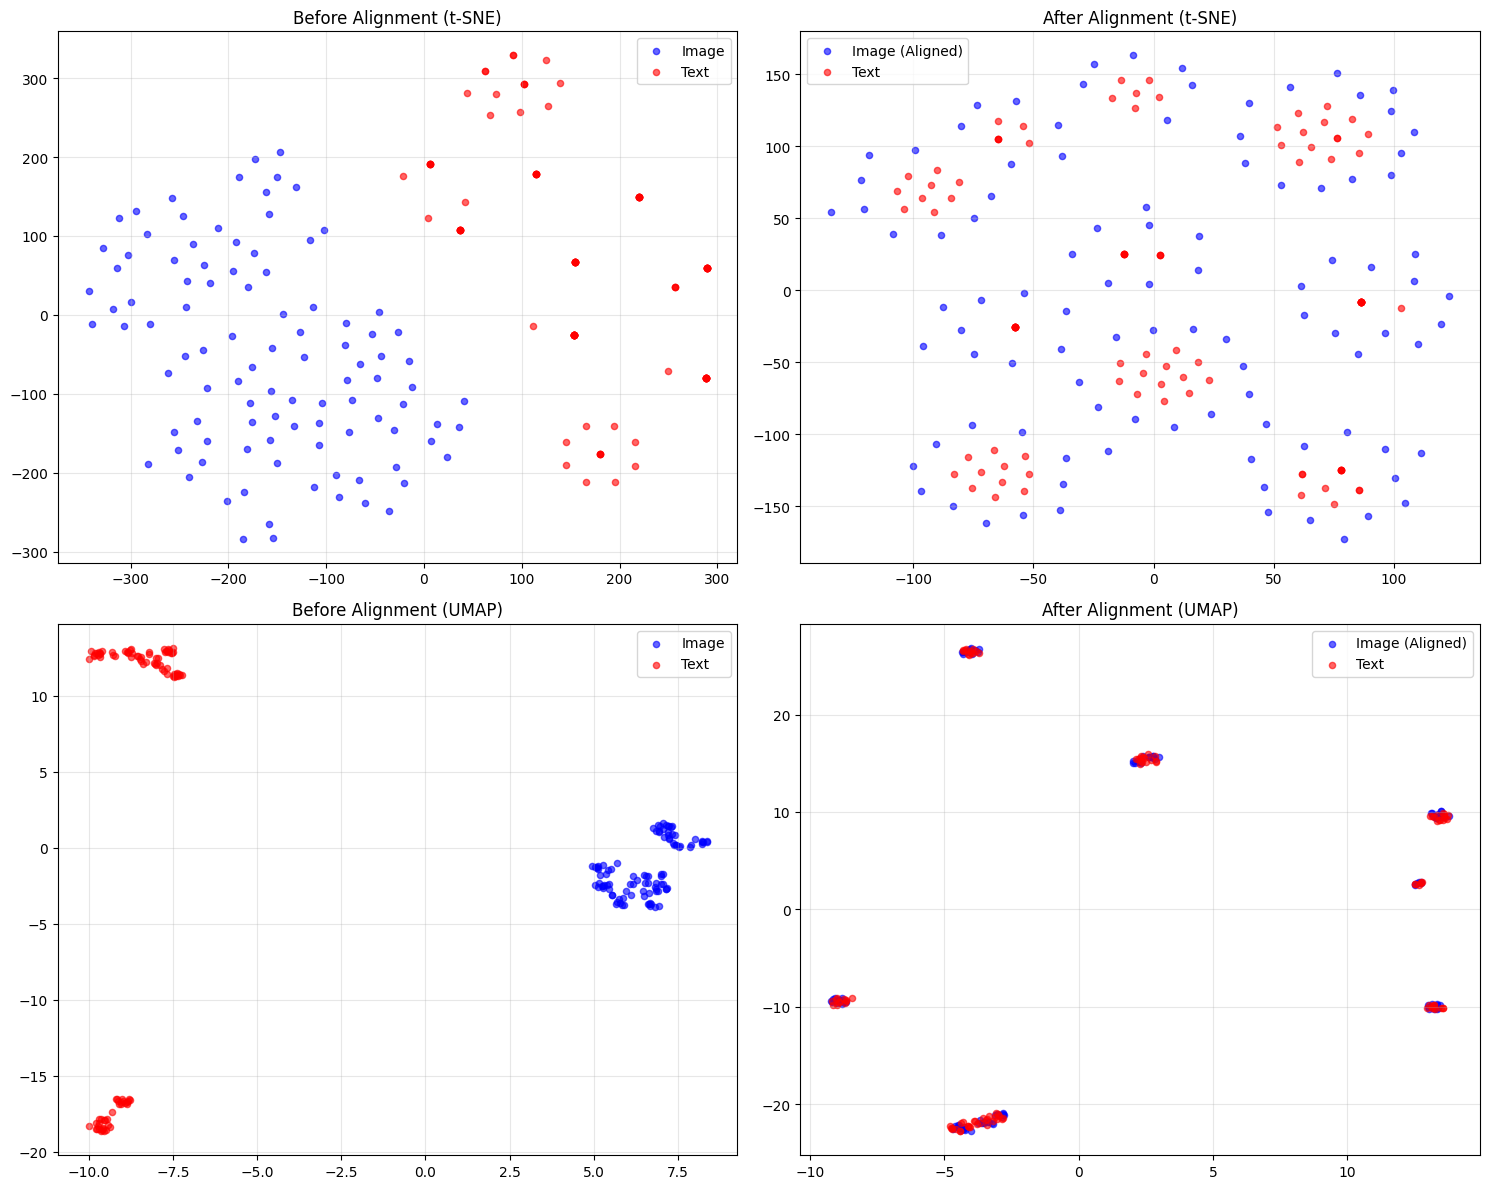


Alignment Results:
Before alignment - Mean diagonal similarity: 0.2791
After alignment - Mean diagonal similarity: 0.8903
Improvement in diagonal similarity: 0.6113

Recomputing classification accuracy with aligned embeddings...

Accuracy Comparison on Subset (100 samples):
Original embeddings: 0.9500
Aligned embeddings: 1.0000
Accuracy change: 0.0500


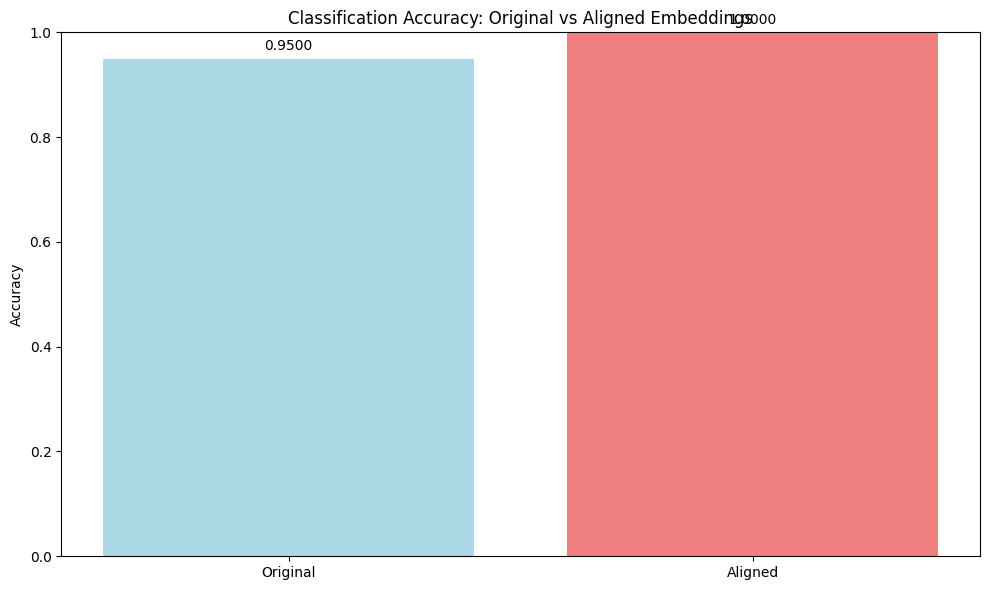

In [5]:

#===============================================================================
# TASK 5.3: Bridging the Modality Gap
#===============================================================================

print("\n=== Task 5.3: Bridging the Modality Gap ===")

# (a-c) Learn optimal rotation matrix using Procrustes alignment
print("Learning optimal rotation matrix...")

# Use normalized embeddings for alignment
X = image_embeddings_norm.numpy()  # Image features
Y = text_embeddings_norm.numpy()   # Text features

# Apply Procrustes alignment
R, scale = orthogonal_procrustes(X, Y)
print(f"Learned rotation matrix R shape: {R.shape}")
print(f"Procrustes scale factor: {scale:.4f}")

# (d) Apply rotation transform
print("Applying rotation transform...")
X_aligned = X @ R
image_embeddings_aligned = torch.from_numpy(X_aligned).float()

# (e) Visualize aligned embeddings
print("Visualizing aligned embeddings...")

# Combine aligned image embeddings with original text embeddings
aligned_all_embeddings = torch.cat([image_embeddings_aligned, text_embeddings_norm], dim=0)
aligned_all_embeddings_np = aligned_all_embeddings.numpy()

# Apply dimensionality reduction to aligned embeddings
aligned_tsne = tsne.fit_transform(aligned_all_embeddings_np)
aligned_umap = umap_reducer.fit_transform(aligned_all_embeddings_np)

# Visualize aligned embeddings
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Before alignment (original)
axes[0, 0].scatter(embeddings_tsne[:len(image_embeddings), 0],
                  embeddings_tsne[:len(image_embeddings), 1],
                  c='blue', alpha=0.6, label='Image', s=20)
axes[0, 0].scatter(embeddings_tsne[len(image_embeddings):, 0],
                  embeddings_tsne[len(image_embeddings):, 1],
                  c='red', alpha=0.6, label='Text', s=20)
axes[0, 0].set_title('Before Alignment (t-SNE)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# After alignment
axes[0, 1].scatter(aligned_tsne[:len(image_embeddings), 0],
                  aligned_tsne[:len(image_embeddings), 1],
                  c='blue', alpha=0.6, label='Image (Aligned)', s=20)
axes[0, 1].scatter(aligned_tsne[len(image_embeddings):, 0],
                  aligned_tsne[len(image_embeddings):, 1],
                  c='red', alpha=0.6, label='Text', s=20)
axes[0, 1].set_title('After Alignment (t-SNE)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# UMAP comparisons
axes[1, 0].scatter(embeddings_umap[:len(image_embeddings), 0],
                  embeddings_umap[:len(image_embeddings), 1],
                  c='blue', alpha=0.6, label='Image', s=20)
axes[1, 0].scatter(embeddings_umap[len(image_embeddings):, 0],
                  embeddings_umap[len(image_embeddings):, 1],
                  c='red', alpha=0.6, label='Text', s=20)
axes[1, 0].set_title('Before Alignment (UMAP)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].scatter(aligned_umap[:len(image_embeddings), 0],
                  aligned_umap[:len(image_embeddings), 1],
                  c='blue', alpha=0.6, label='Image (Aligned)', s=20)
axes[1, 1].scatter(aligned_umap[len(image_embeddings):, 0],
                  aligned_umap[len(image_embeddings):, 1],
                  c='red', alpha=0.6, label='Text', s=20)
axes[1, 1].set_title('After Alignment (UMAP)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Compute alignment metrics
aligned_similarities = torch.mm(
    image_embeddings_aligned.float(),
    text_embeddings_norm.T.float()
)
aligned_diagonal_similarities = torch.diag(aligned_similarities)

print(f"\nAlignment Results:")
print(f"Before alignment - Mean diagonal similarity: {diagonal_similarities.mean():.4f}")
print(f"After alignment - Mean diagonal similarity: {aligned_diagonal_similarities.mean():.4f}")
print(f"Improvement in diagonal similarity: {(aligned_diagonal_similarities.mean() - diagonal_similarities.mean()):.4f}")

# (f) Recompute classification accuracy with aligned embeddings
print("\nRecomputing classification accuracy with aligned embeddings...")

def evaluate_aligned_clip_accuracy(aligned_image_features, text_features, true_labels, class_names):
    """Evaluate accuracy using aligned image features"""
    # Create text features for all classes
    all_text_features = []
    with torch.no_grad():
        for class_name in class_names:
            text_input = f"a photo of a {class_name}"
            text_token = clip.tokenize([text_input]).to(device)
            text_feat = model.encode_text(text_token)
            text_feat = F.normalize(text_feat, dim=1)
            all_text_features.append(text_feat)

        all_text_features = torch.cat(all_text_features, dim=0).cpu()

    # Compute similarities
    similarities = torch.mm(aligned_image_features.float(), all_text_features.T.float())
    predicted_labels = similarities.argmax(dim=1)

    # Compute accuracy
    correct = (predicted_labels == torch.tensor(true_labels)).sum().item()
    accuracy = correct / len(true_labels)

    return accuracy

# Evaluate on the subset
aligned_accuracy = evaluate_aligned_clip_accuracy(
    image_embeddings_aligned,
    text_embeddings_norm,
    labels_list,
    stl10_classes
)

# For comparison, evaluate original embeddings on the same subset
original_accuracy_subset = evaluate_aligned_clip_accuracy(
    image_embeddings_norm,
    text_embeddings_norm,
    labels_list,
    stl10_classes
)

print(f"\nAccuracy Comparison on Subset ({subset_size} samples):")
print(f"Original embeddings: {original_accuracy_subset:.4f}")
print(f"Aligned embeddings: {aligned_accuracy:.4f}")
print(f"Accuracy change: {(aligned_accuracy - original_accuracy_subset):.4f}")

# Visualize accuracy comparison
plt.figure(figsize=(10, 6))
methods = ['Original', 'Aligned']
accuracies_comparison = [original_accuracy_subset, aligned_accuracy]

plt.bar(methods, accuracies_comparison, color=['lightblue', 'lightcoral'])
plt.title('Classification Accuracy: Original vs Aligned Embeddings')
plt.ylabel('Accuracy')
plt.ylim(0, 1)

for i, acc in enumerate(accuracies_comparison):
    plt.text(i, acc + 0.01, f'{acc:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print(f"\n" + "="*80)
